In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import cv2
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

try:
    from google.colab import drive
    drive.mount('/content/drive')
    print('Google Drive mounted successfully.')
except ImportError:
    print('Google Colab not detected. Skipping Drive mount.')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.


In [ ]:
!pip install kaggle -q
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Kaggle"

if not os.path.exists("/content/dataset/Bone Break Classification/Bone Break Classification"):
    print("Downloading dataset...")
    !kaggle datasets download -d pkdarabi/bone-break-classification-image-dataset -p /content/dataset --unzip
else:
    print("Dataset already exists. Skipping download.")

Dataset already exists. Skipping download.


In [ ]:
master_train_dir = '/content/drive/MyDrive/MasterBoneBreak/Train'
master_test_dir = '/content/drive/MyDrive/MasterBoneBreak/Test'

if not os.path.exists(master_train_dir):
    os.makedirs(master_train_dir)
if not os.path.exists(master_test_dir):
    os.makedirs(master_test_dir)

source_base = '/content/dataset/Bone Break Classification/Bone Break Classification'
classes = os.listdir(source_base)

for cls in classes:
    cls_path = os.path.join(source_base, cls)
    train_path = os.path.join(cls_path, 'Train')
    test_path = os.path.join(cls_path, 'Test')

    master_train_class_dir = os.path.join(master_train_dir, cls)
    master_test_class_dir = os.path.join(master_test_dir, cls)

    os.makedirs(master_train_class_dir, exist_ok=True)
    os.makedirs(master_test_class_dir, exist_ok=True)

    if os.path.exists(train_path):
        for img_file in os.listdir(train_path):
            shutil.copy(os.path.join(train_path, img_file), master_train_class_dir)

    if os.path.exists(test_path):
        for img_file in os.listdir(test_path):
            shutil.copy(os.path.join(test_path, img_file), master_test_class_dir)

In [ ]:
#def apply_cahle(image):
    #image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    #clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    #enhanced = clahe.apply(image)
    #enhanced = cv2.equalizeHist(enhanced)
    #kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    #sharpened = cv2.filter2D(enhanced, -1, kernel)
    #sharpened = sharpened / 255.0
    #sharpened = np.stack([sharpened]*3, axis=-1)
    #return sharpened

#def cahle_preprocessing(img):
    #img = img.numpy()
    #img = (img * 255).astype(np.uint8)
    #img = apply_cahle(img)
    #return img

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,       # more rotation
    width_shift_range=0.1,   # horizontal shifts
    height_shift_range=0.1,  # vertical shifts
    zoom_range=0.2,          # more zoom
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

img_size = 128

train_generator = train_datagen.flow_from_directory(
    directory=master_train_dir,
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    directory=master_test_dir,
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode='categorical'
)

print('Detected classes:')
for class_label, index in train_generator.class_indices.items():
    print(f'{index}: {class_label}')

Found 989 images belonging to 10 classes.
Found 140 images belonging to 10 classes.
Detected classes:
0: Avulsion fracture
1: Comminuted fracture
2: Fracture Dislocation
3: Greenstick fracture
4: Hairline Fracture
5: Impacted fracture
6: Longitudinal fracture
7: Oblique fracture
8: Pathological fracture
9: Spiral Fracture


In [ ]:
img_size = 128  # or 224 if you want higher resolution
num_classes = 10

inputs = Input(shape=(img_size, img_size, 3))

# Load ResNet50 base model
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(img_size, img_size, 3)
)

# Freeze the base model
base_model.trainable = False

# Add custom top layers
inputs = Input(shape=(img_size, img_size, 3))
x = Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(256, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(512, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)

x = GlobalAveragePooling2D()(x)

x = Dense(512, activation='relu')(x)
x = Dropout(0.6)(x)

outputs = Dense(num_classes, activation='sigmoid')(x)

bone_model = Model(inputs=inputs, outputs=outputs)


In [ ]:
bone_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05),
    metrics=['accuracy']
)

In [ ]:
bone_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,822,602 (6.95 MB)

 Trainable params: 1,820,682 (6.95 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
# Define LR scheduler separately
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-6
)

# Now fit
history_bone = bone_model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=250,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        lr_schedule
    ]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/250
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 421ms/step - accuracy: 0.1315 - loss: 0.6190 - val_accuracy: 0.1214 - val_loss: 0.6534 - learning_rate: 1.0000e-04
Epoch 2/250
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 279ms/step - accuracy: 0.1389 - loss: 0.4002 - val_accuracy: 0.1000 - val_loss: 0.6116 - learning_rate: 1.0000e-04
Epoch 3/250
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 307ms/step - accuracy: 0.1545 - loss: 0.3904 - val_accuracy: 0.1286 - val_loss: 0.5754 - learning_rate: 1.0000e-04
Epoch 4/250
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 310ms/step - accuracy: 0.1509 - loss: 0.3970 - val_accuracy: 0.1000 - val_loss: 0.5535 - learning_rate: 1.0000e-04
Epoch 5/250
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 272ms/step - accuracy: 0.1909 - loss: 0.3782 - val_accuracy: 0.1000 - val_loss: 0.5369 - learning_rate: 1.0000e-04
Epoch 6/250
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 318ms/step - accuracy: 0.2189 - loss: 0.3679 - val_accuracy: 0.1000 - val_loss: 0.4898 - learning_rate: 1.0000e-04
Epoch 7/250
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 308ms/step 

In [ ]:
loss, acc = bone_model.evaluate(test_generator)
print(f"Test Accuracy (One-vs-All Model with CAHLE + Sharpening): {acc*100:.2f}%")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.3181 - loss: 0.3510
Test Accuracy (One-vs-All Model with CAHLE + Sharpening): 30.71%


In [ ]:
images, true_labels = next(iter(test_generator))
predictions = bone_model.predict(images)
predicted_labels = (predictions > 0.5).astype(int)

print("Raw probabilities for first image:", predictions[0])
print("Binary predictions (thresholded) for first image:", predicted_labels[0])
print("True labels for first image:", true_labels[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step
Raw probabilities for first image: [0.32858005 0.11914769 0.0201814  0.03535568 0.13801426 0.07493819
 0.04506271 0.21856466 0.02398049 0.23429614]
Binary predictions (thresholded) for first image: [0 0 0 0 0 0 0 0 0 0]
True labels for first image: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


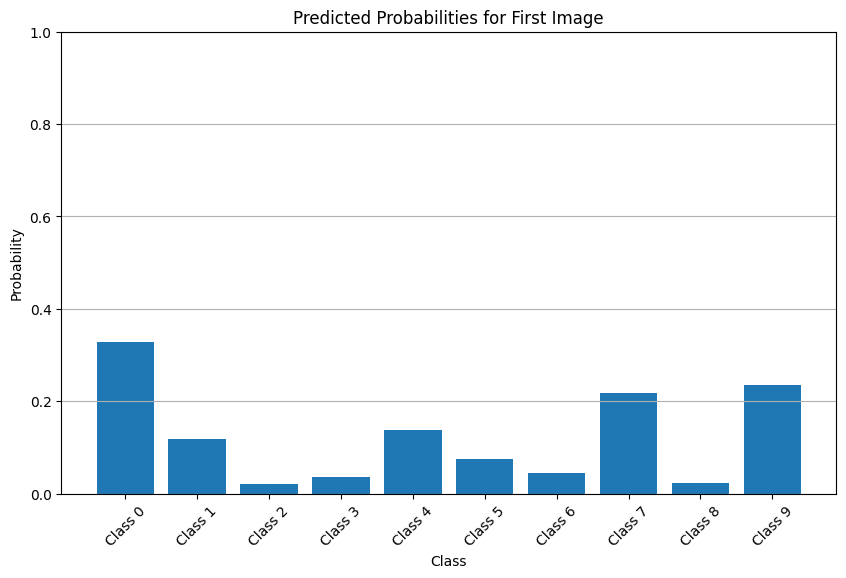

In [ ]:
class_names = [f"Class {i}" for i in range(10)]

plt.figure(figsize=(10,6))
plt.bar(class_names, predictions[0])
plt.title("Predicted Probabilities for First Image")
plt.ylabel("Probability")
plt.xlabel("Class")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

In [ ]:
# Unfreeze the base_model (ResNet50)
base_model.trainable = True

# Recompile the full model with a lower learning rate
bone_model.compile(
    optimizer=Adam(learning_rate=5e-6),  # Small LR for fine-tuning
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05),
    metrics=['accuracy']
)
# Redefine callbacks
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-6
)

# Then continue training
fine_tune_history = bone_model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=100,
    callbacks=[early_stop, lr_schedule]
)

# Continue fine-tuning
fine_tune_history = bone_model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=100,
    callbacks=[early_stop, lr_schedule]
)


Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 18s 393ms/step - accuracy: 0.6718 - loss: 0.2580 - val_accuracy: 0.3071 - val_loss: 0.3550 - learning_rate: 5.0000e-06
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 264ms/step - accuracy: 0.6690 - loss: 0.2559 - val_accuracy: 0.2929 - val_loss: 0.3556 - learning_rate: 5.0000e-06
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 292ms/step - accuracy: 0.7016 - loss: 0.2551 - val_accuracy: 0.2929 - val_loss: 0.3562 - learning_rate: 5.0000e-06
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 292ms/step - accuracy: 0.6949 - loss: 0.2553 - val_accuracy: 0.3000 - val_loss: 0.3566 - learning_rate: 5.0000e-06
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 265ms/step - accuracy: 0.6699 - loss: 0.2570 - val_accuracy: 0.2857 - val_loss: 0.3562 - learning_rate: 5.0000e-06
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.6805 - loss: 0.2543
Epoch 6: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 273ms/step - accurac

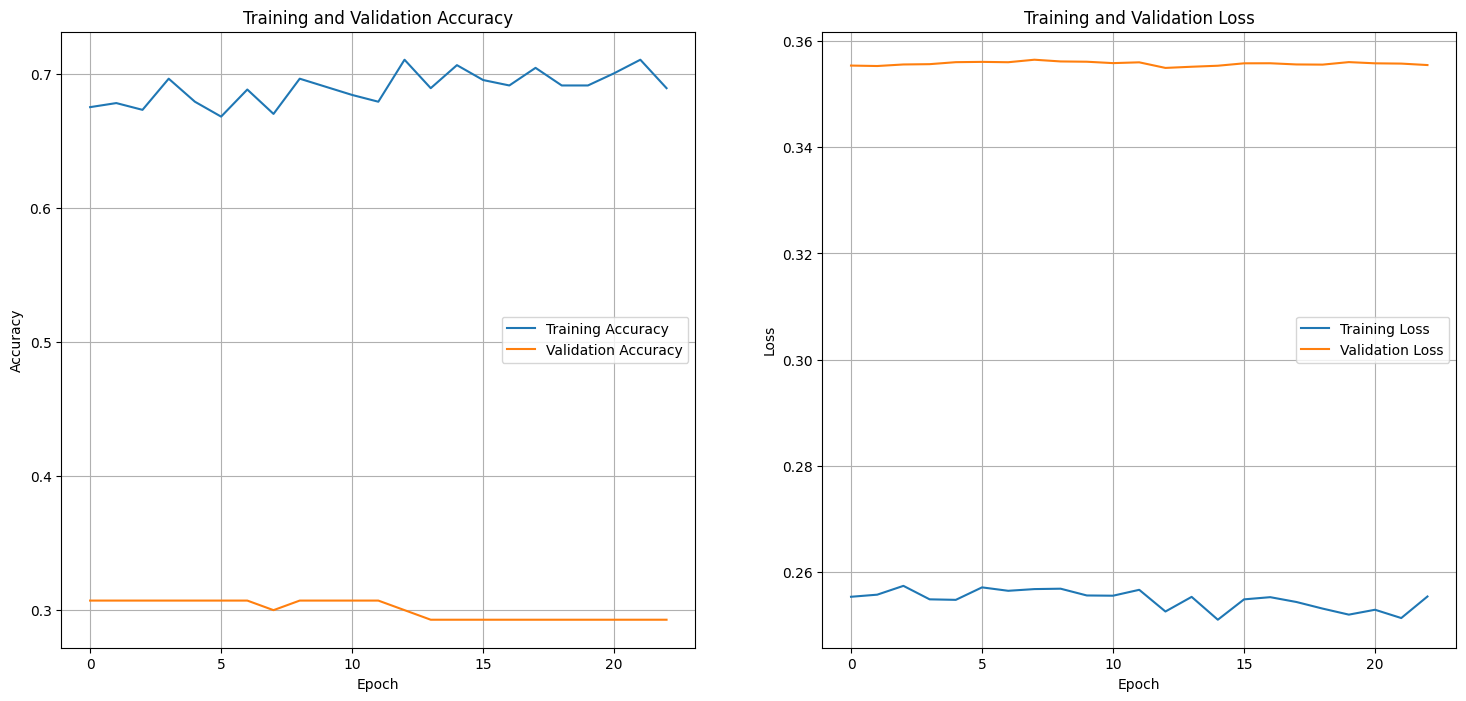

In [ ]:
import matplotlib.pyplot as plt

# Combine training and fine-tuning history if needed
full_accuracy = history_bone.history['accuracy'] + fine_tune_history.history['accuracy']
full_val_accuracy = history_bone.history['val_accuracy'] + fine_tune_history.history['val_accuracy']
full_loss = history_bone.history['loss'] + fine_tune_history.history['loss']
full_val_loss = history_bone.history['val_loss'] + fine_tune_history.history['val_loss']

# Plot everything
plt.figure(figsize=(18,8))

# Accuracy Plot
plt.subplot(1,2,1)
plt.plot(full_accuracy, label='Training Accuracy')
plt.plot(full_val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1,2,2)
plt.plot(full_loss, label='Training Loss')
plt.plot(full_val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()
